# Stacking Models

## Libraries

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##  1. Read data

In [2]:
df = pd.read_csv('creditcard.csv')
df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [3]:
df.shape

(284807, 31)

In [4]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

## 2. Feature selection

In [6]:
X = df.drop('Class', axis =1)
y = df["Class"]

###  Reduce dataset undersampling

In [5]:
from imblearn.under_sampling import RandomUnderSampler

In [8]:
rus = RandomUnderSampler(random_state=1)
X_rus, y_rus = rus.fit_resample(X,y)
X_rus.shape, y_rus.shape

((984, 30), (984,))

In [9]:
y_rus.value_counts()

0    492
1    492
Name: Class, dtype: int64

### Split into train-test

In [10]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, random_state = 42, test_size = .2, stratify=y_rus)

## Build Models

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [14]:
# knn 
knn = KNeighborsClassifier(n_neighbors= 3)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

In [15]:
# SVC
svc = SVC(gamma=2, C=1)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

In [17]:
# DT 
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [18]:
# RF
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [19]:
# MLP
mlp = MLPClassifier(alpha=1, max_iter=1000)
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)

### Evaluation Scores

In [37]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score, plot_confusion_matrix, classification_report

In [21]:
#accuracy
knn_acc = accuracy_score(y_test, knn_pred)
svc_acc = accuracy_score(y_test, svc_pred)
dt_acc = accuracy_score(y_test, dt_pred)
rf_acc = accuracy_score(y_test, rf_pred)
mlp_acc = accuracy_score(y_test, mlp_pred)

In [22]:
#mcc
knn_mcc = matthews_corrcoef(y_test, knn_pred)
svc_mcc = matthews_corrcoef(y_test, svc_pred)
dt_mcc = matthews_corrcoef(y_test, dt_pred)
rf_mcc = matthews_corrcoef(y_test, rf_pred)
mlp_mcc = matthews_corrcoef(y_test, mlp_pred)

In [23]:
#f1_score
knn_f1 = f1_score(y_test, knn_pred)
svc_f1 = f1_score(y_test, svc_pred)
dt_f1 = f1_score(y_test, dt_pred)
rf_f1 = f1_score(y_test, rf_pred)
knn_f1 = f1_score(y_test, knn_pred)

## Build stack model

In [25]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [26]:
estimators = [
    ('knn', knn),
    ('svc', svc),
    ('dt', dt),
    ('rf', rf),
    ('mlp', mlp)
]

In [28]:
stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack_model.fit(X_train, y_train)
stack_pred = stack_model.predict(X_test)

In [29]:
stack_acc = accuracy_score(y_test, stack_pred)
stack_mcc = matthews_corrcoef(y_test, stack_pred)
stack_f1 = f1_score(y_test, stack_pred)

### Scores

In [31]:
acc_list = {'knn': knn_acc,
'svc': svc_acc,
'dt': dt_acc,
'rf': rf_acc,
'mlp': mlp_acc,
'stack': stack_acc}

In [32]:
mcc_list = {'knn': knn_mcc,
'svc': svc_mcc,
'dt': dt_mcc,
'rf': rf_mcc,
'mlp': mlp_mcc,
'stack': stack_mcc}

In [33]:
f1_list = {'knn': knn_f1,
'svc': svc_f1,
'dt': dt_f1,
'rf': rf_f1,
'mlp': mlp_f1,
'stack': stack_f1}

In [36]:
acc_df = pd.DataFrame.from_dict(acc_list, orient='index', columns = ['acc'])
mcc_df = pd.DataFrame.from_dict(mcc_list, orient='index', columns = ['mcc'])
f1_df = pd.DataFrame.from_dict(f1_list, orient='index', columns = ['f1'])
result_score = pd.concat([acc_df, mcc_df, f1_df], axis =1)
result_score.sort_values(by= 'mcc', ascending=False)

,acc,mcc,f1
rf,0.959391,0.919522,0.958333
stack,0.959391,0.918961,0.958763
dt,0.928934,0.857864,0.928571
mlp,0.908629,0.828120,0.900000
knn,0.680203,0.360375,0.676923
svc,0.517766,0.124987,0.059406


In [38]:
# classification report
labels = ['normal', 'fraudes']
print(classification_report(y_test, stack_pred, target_names=labels))

              precision    recall  f1-score   support

      normal       0.95      0.97      0.96        99
     fraudes       0.97      0.95      0.96        98

    accuracy                           0.96       197
   macro avg       0.96      0.96      0.96       197
weighted avg       0.96      0.96      0.96       197



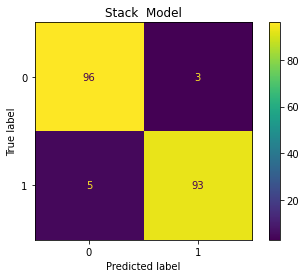

In [41]:
plot_confusion_matrix(stack_model, X_test, y_test)
plt.title('Stack  Model')
plt.show()